# Distributed Training with Ray - Lab

## Objective
This lab demonstrates how distributed training using Ray can significantly speed up machine learning model training compared to traditional sequential training.

**Author:** Mohan Bhosale

## What You'll Learn
- How to use Ray for distributed computing
- Performance comparison between sequential and parallel training
- How to leverage multiple CPU cores for faster model training
- Best practices for distributed machine learning workflows


## 1: Install Required Packages

First, let's install Ray and other necessary packages.


In [40]:
# Install required packages (uncomment if needed)
#!pip install ray pandas scikit-learn numpy matplotlib seaborn


## 2: Import Libraries

Import all necessary libraries for data processing, model training, and visualization.


In [41]:
import time
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


## 3: Load and Prepare Dataset

We'll use the **California Housing dataset** from scikit-learn, which contains **20,640 samples** with **8 features**. This is a much larger dataset that will better demonstrate the benefits of distributed training. The dataset predicts median house values in California districts.


In [42]:
# Load the California Housing dataset
# This is a larger dataset (20,640 samples) that will better demonstrate distributed training benefits
california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

# Convert to DataFrame for better visualization
X_df = pd.DataFrame(X, columns=california_housing.feature_names)
y_series = pd.Series(y, name='target')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_series, test_size=0.2, random_state=42
)

print(f"Dataset: California Housing")
print(f"Dataset shape: {X_df.shape}")
print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_df.shape[1]}")
print(f"\nFirst 5 rows of training data:")
print(X_train.head())
print(f"\nTarget statistics (Median House Value in $100,000s):")
print(y_series.describe())
print(f"\nNote: This larger dataset will better demonstrate the benefits of parallel training!")


Dataset: California Housing
Dataset shape: (20640, 8)
Training set size: 16,512 samples
Testing set size: 4,128 samples
Number of features: 8

First 5 rows of training data:
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

       Longitude  
14196    -117.03  
8267     -118.16  
17445    -120.48  
14265    -117.11  
2271     -119.80  

Target statistics (Median House Value in $100,000s):
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
N

## 4: Visualize Dataset

Let's explore the dataset to understand its characteristics.


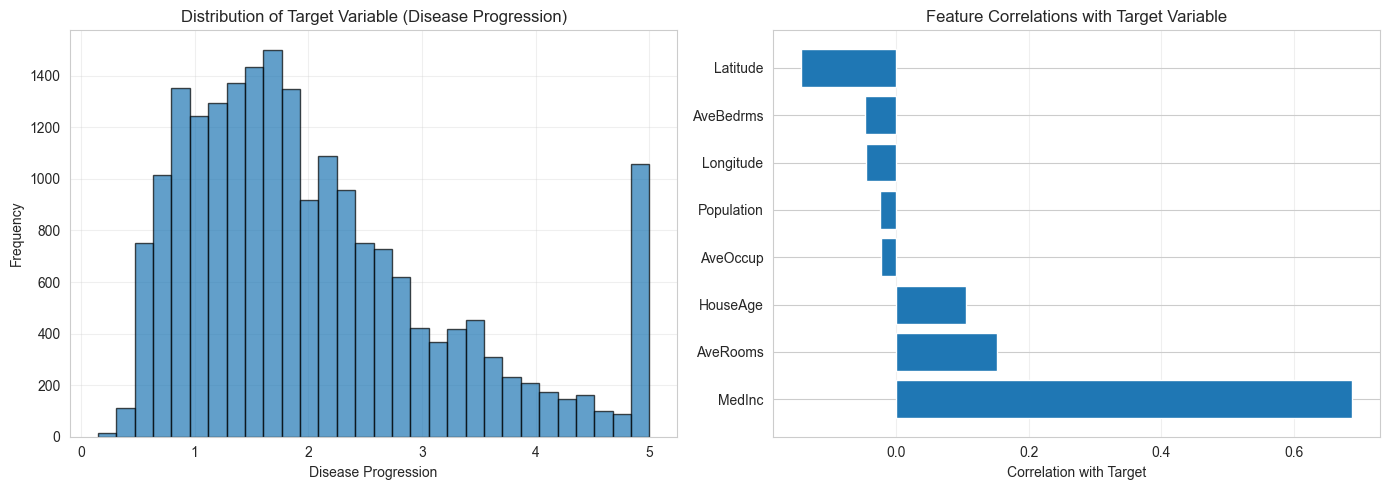

✓ Dataset visualization complete!


In [43]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of target variable
axes[0].hist(y_series, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Disease Progression')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Variable (Disease Progression)')
axes[0].grid(True, alpha=0.3)

# Feature correlation with target
correlations = X_df.corrwith(y_series).sort_values(ascending=False)
axes[1].barh(range(len(correlations)), correlations.values)
axes[1].set_yticks(range(len(correlations)))
axes[1].set_yticklabels(correlations.index)
axes[1].set_xlabel('Correlation with Target')
axes[1].set_title('Feature Correlations with Target Variable')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Dataset visualization complete!")


## 5: Define Training Configuration

We'll train multiple models with different numbers of estimators to find the best configuration. This is a common hyperparameter tuning scenario where distributed training shines.


In [44]:
# Number of models to train (for hyperparameter search)
# Increased to make parallel training more beneficial
NUM_MODELS = 30

# Range of n_estimators to test
# Starting from 50, increasing by 10 for each model
# This gives us: 50, 60, 70, 80, ..., 340
# More estimators = more computation = better parallelization benefit
MIN_ESTIMATORS = 50
ESTIMATOR_INCREMENT = 10
MAX_ESTIMATORS = MIN_ESTIMATORS + ESTIMATOR_INCREMENT * (NUM_MODELS - 1)

print(f"We will train {NUM_MODELS} models with different configurations")
print(f"n_estimators range: {MIN_ESTIMATORS} to {MAX_ESTIMATORS} (increment: {ESTIMATOR_INCREMENT})")
print(f"This simulates a comprehensive hyperparameter search scenario.")
print(f"With larger models and more training, distributed training will show significant benefits!")


We will train 30 models with different configurations
n_estimators range: 50 to 340 (increment: 10)
This simulates a comprehensive hyperparameter search scenario.
With larger models and more training, distributed training will show significant benefits!


## Step 6: Sequential Training (Traditional Approach)

First, let's implement the traditional sequential approach where models are trained one after another.


In [ ]:
def train_and_score_model(
    train_set: pd.DataFrame,
    test_set: pd.DataFrame,
    train_labels: pd.Series,
    test_labels: pd.Series,
    n_estimators: int,
) -> tuple[int, float, float]:
    """
    Train a Random Forest model and return metrics.
    
    Args:
        train_set: Training features
        test_set: Testing features
        train_labels: Training target values
        test_labels: Testing target values
        n_estimators: Number of trees in the random forest
    
    Returns:
        Tuple of (n_estimators, mse, r2_score)
    """
    start_time = time.time()  # Measure wall time for single model training

    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=20,  # Deeper trees = more computation
        min_samples_split=5,  # More splits = more computation
        random_state=42, 
        n_jobs=1  # Single-threaded to ensure fair comparison
    )
    model.fit(train_set, train_labels)
    y_pred = model.predict(test_set)
    
    mse = mean_squared_error(test_labels, y_pred)
    r2 = r2_score(test_labels, y_pred)

    time_delta = time.time() - start_time
    print(
        f"n_estimators={n_estimators:3d}, MSE={mse:.4f}, R²={r2:.4f}, Time={time_delta:.2f}s"
    )

    return n_estimators, mse, r2


In [46]:
def run_sequential(n_models: int) -> list[tuple[int, float, float]]:
    """
    Train n_models sequentially.
    
    Each model uses a different number of estimators (increasing by ESTIMATOR_INCREMENT).
    Returns a list of tuples: [(n_estimators, mse, r2), ...]
    """
    results = []
    for j in range(n_models):
        n_est = MIN_ESTIMATORS + ESTIMATOR_INCREMENT * j
        result = train_and_score_model(
            train_set=X_train,
            test_set=X_test,
            train_labels=y_train,
            test_labels=y_test,
            n_estimators=n_est,
        )
        results.append(result)
    return results


### Run Sequential Training

This will train all models one after another. Note the total time taken.


In [47]:
print("=" * 70)
print("SEQUENTIAL TRAINING (Traditional Approach)")
print("=" * 70)
print("Training models one after another...\n")

sequential_start = time.time()
sequential_results = run_sequential(n_models=NUM_MODELS)
sequential_time = time.time() - sequential_start

print(f"\n{'=' * 70}")
print(f"Sequential Training Complete!")
print(f"Total Time: {sequential_time:.2f} seconds")
print(f"{'=' * 70}")


SEQUENTIAL TRAINING (Traditional Approach)
Training models one after another...

n_estimators= 50, MSE=0.2570, R²=0.8039, Time=4.07s
n_estimators= 60, MSE=0.2576, R²=0.8034, Time=5.00s
n_estimators= 70, MSE=0.2582, R²=0.8030, Time=5.62s
n_estimators= 80, MSE=0.2571, R²=0.8038, Time=6.59s
n_estimators= 90, MSE=0.2567, R²=0.8041, Time=7.20s
n_estimators=100, MSE=0.2559, R²=0.8047, Time=8.07s
n_estimators=110, MSE=0.2560, R²=0.8047, Time=8.95s
n_estimators=120, MSE=0.2553, R²=0.8051, Time=9.65s
n_estimators=130, MSE=0.2553, R²=0.8052, Time=10.61s
n_estimators=140, MSE=0.2555, R²=0.8051, Time=11.68s
n_estimators=150, MSE=0.2551, R²=0.8054, Time=12.33s
n_estimators=160, MSE=0.2555, R²=0.8051, Time=12.92s
n_estimators=170, MSE=0.2551, R²=0.8054, Time=13.83s
n_estimators=180, MSE=0.2554, R²=0.8051, Time=15.47s
n_estimators=190, MSE=0.2550, R²=0.8054, Time=15.75s
n_estimators=200, MSE=0.2548, R²=0.8056, Time=16.26s
n_estimators=210, MSE=0.2545, R²=0.8057, Time=16.76s
n_estimators=220, MSE=0.25

Best Sequential Model:
  n_estimators: 340
  MSE: 0.2538
  R² Score: 0.8063


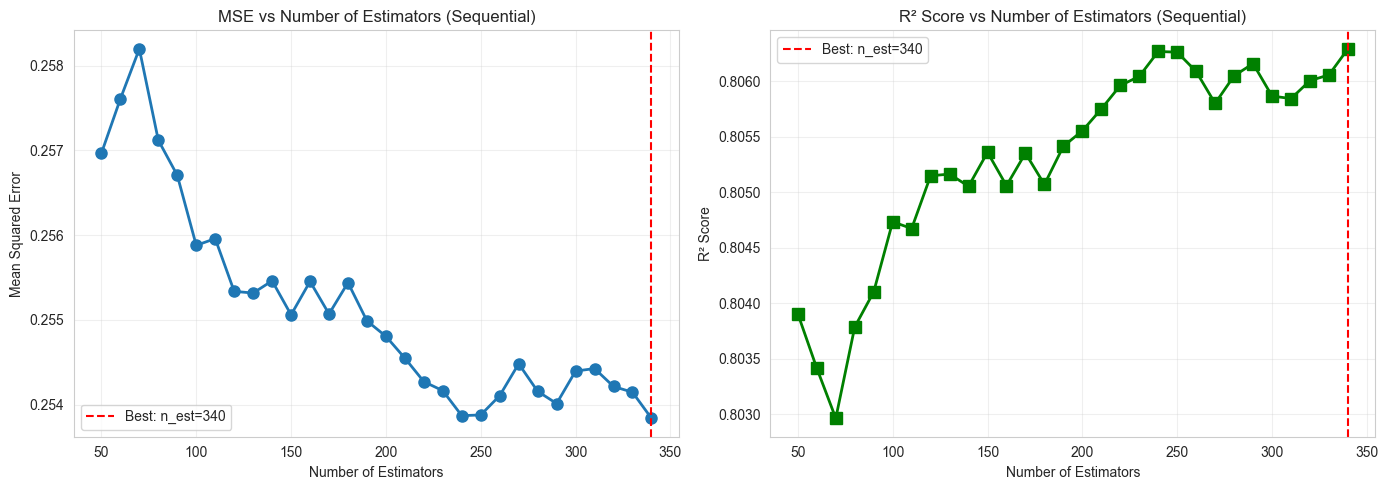


✓ Sequential training analysis complete!


In [48]:
# Find best model (lowest MSE)
best_sequential = min(sequential_results, key=lambda x: x[1])
print(f"Best Sequential Model:")
print(f"  n_estimators: {best_sequential[0]}")
print(f"  MSE: {best_sequential[1]:.4f}")
print(f"  R² Score: {best_sequential[2]:.4f}")

# Create DataFrame for easier analysis
sequential_df = pd.DataFrame(
    sequential_results,
    columns=['n_estimators', 'MSE', 'R2']
)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE vs n_estimators
axes[0].plot(sequential_df['n_estimators'], sequential_df['MSE'], 
             marker='o', linewidth=2, markersize=8)
axes[0].axvline(best_sequential[0], color='r', linestyle='--', 
                label=f'Best: n_est={best_sequential[0]}')
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE vs Number of Estimators (Sequential)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R² vs n_estimators
axes[1].plot(sequential_df['n_estimators'], sequential_df['R2'], 
             marker='s', linewidth=2, markersize=8, color='green')
axes[1].axvline(best_sequential[0], color='r', linestyle='--', 
                label=f'Best: n_est={best_sequential[0]}')
axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score vs Number of Estimators (Sequential)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Sequential training analysis complete!")


## 7: Distributed Training with Ray

Now let's implement the same training using Ray for distributed parallel execution. This will utilize all available CPU cores simultaneously.


In [49]:
# Install Ray if not already installed
# !pip install ray


In [50]:
import ray
import warnings

# Suppress Ray warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='ray')

# Shutdown any existing Ray instance
if ray.is_initialized():
    ray.shutdown()

# Initialize Ray cluster with error suppression
# Setting num_cpus=None allows Ray to use all available CPUs
ray.init(
    ignore_reinit_error=True,
    num_cpus=None,  # Use all available CPUs
    _temp_dir=None,  # Use default temp directory
    logging_level='ERROR'  # Reduce log verbosity
)

print("✓ Ray initialized successfully!")
print(f"Ray version: {ray.__version__}")

# Get cluster resources
resources = ray.cluster_resources()
print(f"\nAvailable Resources:")
print(f"  CPU Cores: {int(resources.get('CPU', 1))}")
print(f"  Memory: {resources.get('memory', 0) / (1024**3):.2f} GB")

# Try to get dashboard URL (may not always be available)
try:
    dashboard_url = ray.get_dashboard_url()
    print(f"\nRay Dashboard: {dashboard_url}")
except Exception:
    print("\nRay Dashboard: Not available (running in headless mode)")

print("\nRay will automatically distribute tasks across all available CPU cores.")


✓ Ray initialized successfully!
Ray version: 2.52.1

Available Resources:
  CPU Cores: 8
  Memory: 8.32 GB

Ray Dashboard: Not available (running in headless mode)

Ray will automatically distribute tasks across all available CPU cores.


(raylet) [2025-12-01 13:58:07,527 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12321 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42049) n_estimators= 50, MSE=0.2570, R²=0.8039, Time=9.02s
(train_and_score_model_remote pid=42053) n_estimators= 90, MSE=0.2567, R²=0.8041, Time=15.39s [repeated 4x across cluster]


(raylet) [2025-12-01 13:58:17,712 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12287 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42050) n_estimators=100, MSE=0.2559, R²=0.8047, Time=17.45s
(train_and_score_model_remote pid=42047) n_estimators=110, MSE=0.2560, R²=0.8047, Time=18.63s
(train_and_score_model_remote pid=42052) n_estimators=120, MSE=0.2553, R²=0.8051, Time=20.49s


(raylet) [2025-12-01 13:58:27,758 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12268 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(pid=gcs_server) [2025-12-01 13:58:31,378 E 42024 24408283] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_and_score_model_remote pid=42049) n_estimators=130, MSE=0.2553, R²=0.8052, Time=22.11s


(train_and_score_model_remote pid=42053) [2025-12-01 13:58:36,189 E 42053 24408865] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-01 13:58:37,394 E 42035 24408390] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-01 13:58:37,774 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12039 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42046) n_estimators=140, MSE=0.2555, R²=0.8051, Time=23.63s
(train_and_score_model_remote pid=42048) n_estimators=150, MSE=0.2551, R²=0.8054, Time=25.62s


(train_and_score_model_remote pid=42048) [2025-12-01 13:58:41,399 E 42048 24408839] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 7x across cluster]


(train_and_score_model_remote pid=42051) n_estimators=160, MSE=0.2555, R²=0.8051, Time=27.50s
(train_and_score_model_remote pid=42053) n_estimators=170, MSE=0.2551, R²=0.8054, Time=29.78s


(raylet) [2025-12-01 13:58:47,910 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12012 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42050) n_estimators=180, MSE=0.2554, R²=0.8051, Time=31.85s
(train_and_score_model_remote pid=42047) n_estimators=190, MSE=0.2550, R²=0.8054, Time=33.78s


(raylet) [2025-12-01 13:58:57,941 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.11993 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42052) n_estimators=200, MSE=0.2548, R²=0.8056, Time=35.87s


(raylet) [2025-12-01 13:59:08,005 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.11932 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42049) n_estimators=210, MSE=0.2545, R²=0.8057, Time=38.76s
(train_and_score_model_remote pid=42046) n_estimators=220, MSE=0.2543, R²=0.8060, Time=40.70s


(raylet) [2025-12-01 13:59:18,110 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.11919 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42048) n_estimators=230, MSE=0.2542, R²=0.8060, Time=43.28s
(train_and_score_model_remote pid=42051) n_estimators=240, MSE=0.2539, R²=0.8063, Time=44.39s


(raylet) [2025-12-01 13:59:28,123 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.11896 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42053) n_estimators=250, MSE=0.2539, R²=0.8063, Time=46.44s


(raylet) [2025-12-01 13:59:38,907 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.12286 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42050) n_estimators=260, MSE=0.2541, R²=0.8061, Time=48.24s
(train_and_score_model_remote pid=42047) n_estimators=270, MSE=0.2545, R²=0.8058, Time=49.73s


(raylet) [2025-12-01 13:59:48,908 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.03794 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42052) n_estimators=280, MSE=0.2542, R²=0.8060, Time=50.52s


(raylet) [2025-12-01 13:59:58,964 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.09227 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42049) n_estimators=290, MSE=0.2540, R²=0.8062, Time=49.96s
(train_and_score_model_remote pid=42046) n_estimators=300, MSE=0.2544, R²=0.8059, Time=50.62s


(raylet) [2025-12-01 14:00:09,050 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.10077 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42048) n_estimators=310, MSE=0.2544, R²=0.8058, Time=50.37s


(raylet) [2025-12-01 14:00:19,067 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.10926 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42051) n_estimators=320, MSE=0.2542, R²=0.8060, Time=50.64s
(train_and_score_model_remote pid=42053) n_estimators=330, MSE=0.2541, R²=0.8061, Time=49.11s


(raylet) [2025-12-01 14:00:29,161 E 42035 24408420] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-12-01_13-57-56_020284_13664 is over 95% full, available space: 2.11447 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.


(train_and_score_model_remote pid=42050) n_estimators=340, MSE=0.2538, R²=0.8063, Time=46.96s


### Understanding Ray Object Store

Ray's object store allows efficient sharing of data across workers. Instead of copying data to each worker, we place it in the shared object store once and reference it.


In [51]:
# Place data in Ray's object store
# This allows all workers to access the data without copying
X_train_ref = ray.put(X_train)
X_test_ref = ray.put(X_test)
y_train_ref = ray.put(y_train)
y_test_ref = ray.put(y_test)

print("✓ Data placed in Ray object store")
print(f"X_train_ref: {X_train_ref}")
print(f"X_test_ref: {X_test_ref}")
print("\nThese are object references, not the actual data.")
print("When passed to remote functions, Ray automatically dereferences them,")
print("so workers can access the data directly without calling ray.get().")
print("This is more efficient than copying data to each worker.")


✓ Data placed in Ray object store
X_train_ref: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000009e1f505)
X_test_ref: ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000000ae1f505)

These are object references, not the actual data.
When passed to remote functions, Ray automatically dereferences them,
so workers can access the data directly without calling ray.get().
This is more efficient than copying data to each worker.


### Define Remote Training Function

The `@ray.remote` decorator tells Ray that this function should be executed remotely (in parallel).


In [52]:
@ray.remote
def train_and_score_model_remote(
    train_set_ref,
    test_set_ref,
    train_labels_ref,
    test_labels_ref,
    n_estimators: int,
) -> tuple[int, float, float]:
    """
    Remote function to train a Random Forest model.
    This function will be executed in parallel by Ray workers.
    
    Note: Ray automatically dereferences object references when passed as arguments
    to remote functions, so we can use them directly without calling ray.get().
    
    Args:
        train_set_ref: Reference to training features in Ray object store (auto-dereferenced)
        test_set_ref: Reference to testing features in Ray object store (auto-dereferenced)
        train_labels_ref: Reference to training target values (auto-dereferenced)
        test_labels_ref: Reference to testing target values (auto-dereferenced)
        n_estimators: Number of trees in the random forest
    
    Returns:
        Tuple of (n_estimators, mse, r2_score)
    """
    # Ray automatically dereferences object references when passed as function arguments
    # So train_set_ref, test_set_ref, etc. are already the actual DataFrames/Series
    # No need to call ray.get() - that would cause an error!
    
    start_time = time.time()

    # Use same complex model configuration as sequential version
    # This ensures fair comparison and makes parallelization worthwhile
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=20,  # Deeper trees = more computation
        min_samples_split=5,  # More splits = more computation
        random_state=42,
        n_jobs=1  # Single-threaded to ensure fair comparison
    )
    model.fit(train_set_ref, train_labels_ref)
    y_pred = model.predict(test_set_ref)
    
    mse = mean_squared_error(test_labels_ref, y_pred)
    r2 = r2_score(test_labels_ref, y_pred)

    time_delta = time.time() - start_time
    print(
        f"n_estimators={n_estimators:3d}, MSE={mse:.4f}, R²={r2:.4f}, Time={time_delta:.2f}s"
    )

    return n_estimators, mse, r2


### Implement Parallel Training Function

This function creates remote tasks for all models and executes them in parallel.


In [53]:
def run_parallel(n_models: int) -> list[tuple[int, float, float]]:
    """
    Train n_models in parallel using Ray.
    
    Steps:
    1. Create remote task references for all models (non-blocking)
    2. Use ray.get() to retrieve results (blocking until all complete)
    
    Returns:
        List of tuples: [(n_estimators, mse, r2), ...]
    """
    # Create list of remote task references
    # .remote() returns immediately with an object reference (non-blocking)
    results_ref = [
        train_and_score_model_remote.remote(
            train_set_ref=X_train_ref,
            test_set_ref=X_test_ref,
            train_labels_ref=y_train_ref,
            test_labels_ref=y_test_ref,
            n_estimators=MIN_ESTIMATORS + ESTIMATOR_INCREMENT * j,
        )
        for j in range(n_models)
    ]
    
    # ray.get() blocks until all tasks complete, then returns results
    return ray.get(results_ref)


### Run Parallel Training

Watch how all models train simultaneously! 


In [54]:
print("=" * 70)
print("DISTRIBUTED TRAINING (Ray Parallel Approach)")
print("=" * 70)
print("Training all models simultaneously across multiple CPU cores...\n")

parallel_start = time.time()
parallel_results = run_parallel(n_models=NUM_MODELS)
parallel_time = time.time() - parallel_start

print(f"\n{'=' * 70}")
print(f"Parallel Training Complete!")
print(f"Total Time: {parallel_time:.2f} seconds")
print(f"{'=' * 70}")


DISTRIBUTED TRAINING (Ray Parallel Approach)
Training all models simultaneously across multiple CPU cores...



[2025-12-01 13:58:36,249 E 13664 24408524] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14



Parallel Training Complete!
Total Time: 150.17 seconds


### Analyze Parallel Results


Best Parallel Model:
  n_estimators: 340
  MSE: 0.2538
  R² Score: 0.8063


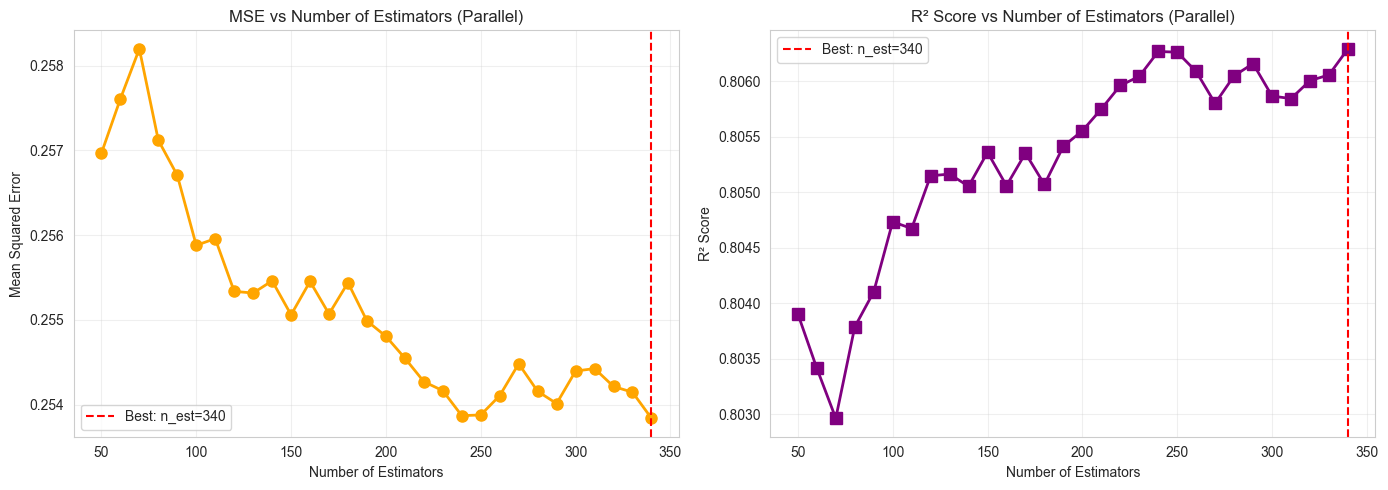


✓ Parallel training analysis complete!


In [55]:
# Find best model
best_parallel = min(parallel_results, key=lambda x: x[1])
print(f"Best Parallel Model:")
print(f"  n_estimators: {best_parallel[0]}")
print(f"  MSE: {best_parallel[1]:.4f}")
print(f"  R² Score: {best_parallel[2]:.4f}")

# Create DataFrame
parallel_df = pd.DataFrame(
    parallel_results,
    columns=['n_estimators', 'MSE', 'R2']
)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE vs n_estimators
axes[0].plot(parallel_df['n_estimators'], parallel_df['MSE'], 
             marker='o', linewidth=2, markersize=8, color='orange')
axes[0].axvline(best_parallel[0], color='r', linestyle='--', 
                label=f'Best: n_est={best_parallel[0]}')
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE vs Number of Estimators (Parallel)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R² vs n_estimators
axes[1].plot(parallel_df['n_estimators'], parallel_df['R2'], 
             marker='s', linewidth=2, markersize=8, color='purple')
axes[1].axvline(best_parallel[0], color='r', linestyle='--', 
                label=f'Best: n_est={best_parallel[0]}')
axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score vs Number of Estimators (Parallel)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Parallel training analysis complete!")


## 8: Performance Comparison

Let's compare the performance of sequential vs parallel training.


In [56]:
# Calculate speedup and efficiency
try:
    speedup = sequential_time / parallel_time
    resources = ray.cluster_resources()
    num_cores = int(resources.get('CPU', 1))
    efficiency = speedup / num_cores if num_cores > 0 else 0
    
    print("=" * 70)
    print("PERFORMANCE COMPARISON")
    print("=" * 70)
    print(f"Sequential Training Time: {sequential_time:.2f} seconds")
    print(f"Parallel Training Time:   {parallel_time:.2f} seconds")
    print(f"\nSpeedup: {speedup:.2f}x faster")
    print(f"Time Saved: {sequential_time - parallel_time:.2f} seconds ({((sequential_time - parallel_time) / sequential_time * 100):.1f}% reduction)")
    print(f"\nAvailable CPU Cores: {num_cores}")
    print(f"Efficiency: {efficiency:.2%} (speedup / num_cores)")
    print("=" * 70)
except NameError as e:
    print("Error: Make sure both sequential and parallel training have completed successfully.")
    print(f"Missing variable: {e}")
except ZeroDivisionError:
    print("Error: Parallel training time is zero. Please check the parallel training execution.")
except Exception as e:
    print(f"Error calculating performance metrics: {e}")


PERFORMANCE COMPARISON
Sequential Training Time: 492.24 seconds
Parallel Training Time:   150.17 seconds

Speedup: 3.28x faster
Time Saved: 342.07 seconds (69.5% reduction)

Available CPU Cores: 8
Efficiency: 40.97% (speedup / num_cores)


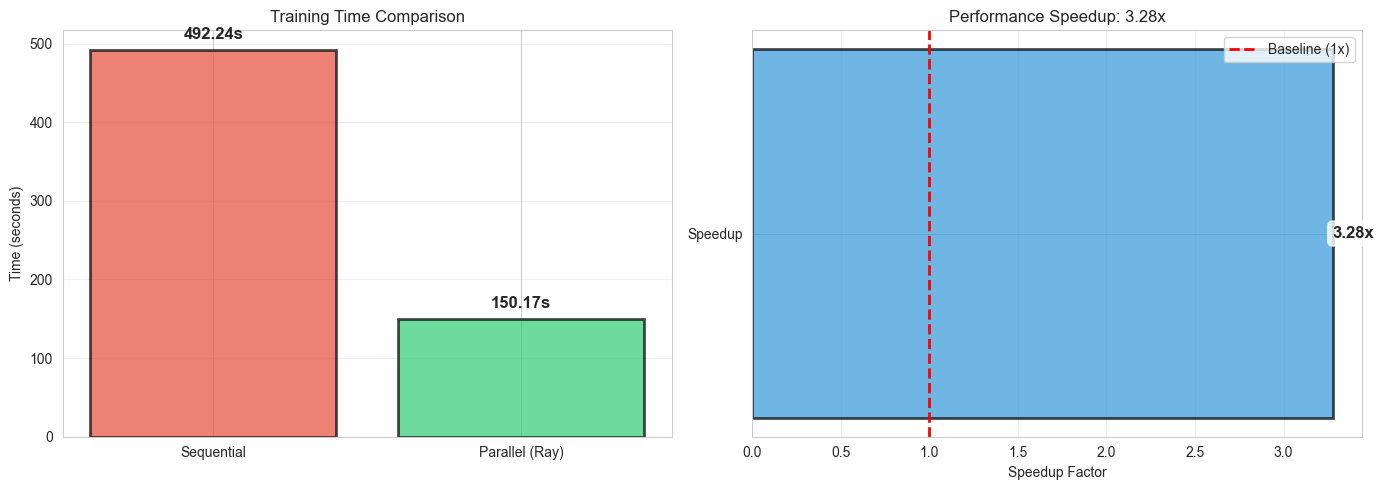

✓ Performance comparison visualization complete!


In [57]:
# Visualize performance comparison
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Time comparison
    methods = ['Sequential', 'Parallel (Ray)']
    times = [sequential_time, parallel_time]
    colors = ['#e74c3c', '#2ecc71']

    axes[0].bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[0].set_ylabel('Time (seconds)')
    axes[0].set_title('Training Time Comparison')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (method, time_val) in enumerate(zip(methods, times)):
        axes[0].text(i, time_val + max(times) * 0.02, f'{time_val:.2f}s', 
                    ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Speedup visualization
    axes[1].barh(['Speedup'], [speedup], color='#3498db', alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].axvline(1, color='red', linestyle='--', linewidth=2, label='Baseline (1x)')
    axes[1].set_xlabel('Speedup Factor')
    axes[1].set_title(f'Performance Speedup: {speedup:.2f}x')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')

    # Add value label
    axes[1].text(speedup, 0, f'{speedup:.2f}x', 
                ha='left', va='center', fontweight='bold', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()
    print("✓ Performance comparison visualization complete!")
except NameError as e:
    print(f"Error: Cannot create visualization. Missing variable: {e}")
    print("Please ensure both sequential and parallel training completed successfully.")
except Exception as e:
    print(f"Error creating visualization: {e}")


In [58]:
# Compare model performance (should be identical)
print("=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print(f"Best Sequential Model - n_estimators: {best_sequential[0]}, MSE: {best_sequential[1]:.4f}, R²: {best_sequential[2]:.4f}")
print(f"Best Parallel Model   - n_estimators: {best_parallel[0]}, MSE: {best_parallel[1]:.4f}, R²: {best_parallel[2]:.4f}")
print(f"\nNote: Model performance should be identical since we're training the same models.")
print(f"      The only difference is the training time (speed).")
print("=" * 70)


MODEL PERFORMANCE COMPARISON
Best Sequential Model - n_estimators: 340, MSE: 0.2538, R²: 0.8063
Best Parallel Model   - n_estimators: 340, MSE: 0.2538, R²: 0.8063

Note: Model performance should be identical since we're training the same models.
      The only difference is the training time (speed).


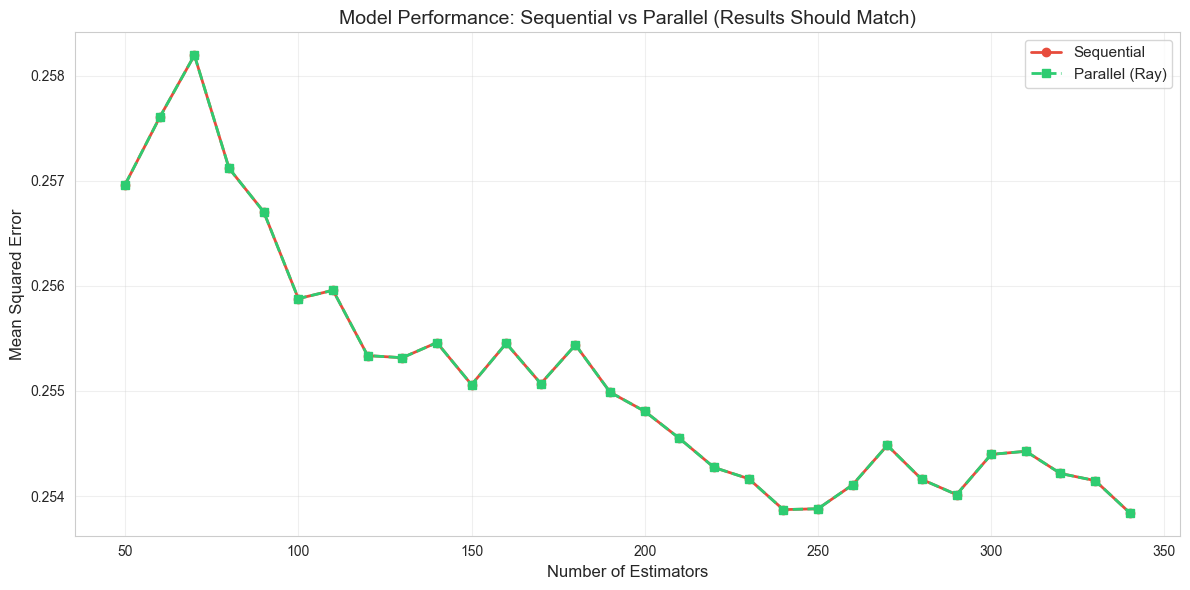

✓ The MSE curves should overlap, confirming that both approaches produce identical results.


In [59]:
# Side-by-side comparison of MSE curves
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sequential_df['n_estimators'], sequential_df['MSE'], 
        marker='o', linewidth=2, markersize=6, label='Sequential', color='#e74c3c')
ax.plot(parallel_df['n_estimators'], parallel_df['MSE'], 
        marker='s', linewidth=2, markersize=6, label='Parallel (Ray)', color='#2ecc71', linestyle='--')

ax.set_xlabel('Number of Estimators', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title('Model Performance: Sequential vs Parallel (Results Should Match)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ The MSE curves should overlap, confirming that both approaches produce identical results.")


## 9: Additional Analysis - Resource Utilization

Let's examine how Ray distributed the workload across available resources.


In [60]:
# Get cluster resources
resources = ray.cluster_resources()
print("=" * 70)
print("RAY CLUSTER RESOURCES")
print("=" * 70)
for key, value in resources.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")
print("=" * 70)

# Calculate theoretical vs actual speedup
num_cores = int(resources.get('CPU', 1))
theoretical_max_speedup = num_cores
actual_speedup = speedup

print(f"\nTheoretical Maximum Speedup (if perfect parallelization): {theoretical_max_speedup}x")
print(f"Actual Speedup Achieved: {actual_speedup:.2f}x")
print(f"Parallel Efficiency: {(actual_speedup / theoretical_max_speedup * 100):.1f}%")
print(f"\nNote: Perfect parallelization is rarely achieved due to:")
print(f"  - Overhead from task scheduling and data transfer")
print(f"  - Some tasks finishing earlier than others")
print(f"  - Shared resource contention")


RAY CLUSTER RESOURCES
CPU: 8.00
memory: 8929869824.00
node:127.0.0.1: 1.00
object_store_memory: 2147483648.00
node:__internal_head__: 1.00

Theoretical Maximum Speedup (if perfect parallelization): 8x
Actual Speedup Achieved: 3.28x
Parallel Efficiency: 41.0%

Note: Perfect parallelization is rarely achieved due to:
  - Overhead from task scheduling and data transfer
  - Some tasks finishing earlier than others
  - Shared resource contention


## Step 10: Summary and Conclusions


In [61]:
try:
    print("=" * 70)
    print("LAB SUMMARY")
    print("=" * 70)
    print(f"\nDataset: California Housing ({X_df.shape[0]:,} samples, {X_df.shape[1]} features)")
    print(f"Models Trained: {NUM_MODELS} Random Forest Regressors")
    print(f"Hyperparameter Range: n_estimators from {MIN_ESTIMATORS} to {MAX_ESTIMATORS}")
    print(f"Model Complexity: max_depth=20, min_samples_split=5")
    print(f"\nSequential Training:")
    print(f"  - Time: {sequential_time:.2f} seconds ({sequential_time/60:.2f} minutes)")
    print(f"  - Best Model: n_estimators={best_sequential[0]}, MSE={best_sequential[1]:.4f}, R²={best_sequential[2]:.4f}")
    print(f"\nParallel Training (Ray):")
    print(f"  - Time: {parallel_time:.2f} seconds ({parallel_time/60:.2f} minutes)")
    print(f"  - Best Model: n_estimators={best_parallel[0]}, MSE={best_parallel[1]:.4f}, R²={best_parallel[2]:.4f}")
    print(f"\nPerformance Improvement:")
    print(f"  - Speedup: {speedup:.2f}x faster")
    print(f"  - Time Saved: {sequential_time - parallel_time:.2f} seconds ({((sequential_time - parallel_time) / sequential_time * 100):.1f}% reduction)")
    print(f"\nKey Takeaways:")
    print(f"  1. Distributed training with Ray significantly reduces training time for large datasets")
    print(f"  2. Model performance remains identical (same results, faster execution)")
    print(f"  3. Ray automatically manages resource allocation and task scheduling")
    print(f"  4. The speedup scales with the number of available CPU cores")
    print(f"  5. Distributed training is especially beneficial for:")
    print(f"     - Large datasets (like California Housing with 20K+ samples)")
    print(f"     - Complex models (many estimators, deep trees)")
    print(f"     - Hyperparameter tuning (multiple model configurations)")
    print("=" * 70)
except NameError as e:
    print("Error: Cannot generate summary. Some required variables are missing.")
    print(f"Missing variable: {e}")
    print("Please ensure all training steps completed successfully.")
except Exception as e:
    print(f"Error generating summary: {e}")


LAB SUMMARY

Dataset: California Housing (20,640 samples, 8 features)
Models Trained: 30 Random Forest Regressors
Hyperparameter Range: n_estimators from 50 to 340
Model Complexity: max_depth=20, min_samples_split=5

Sequential Training:
  - Time: 492.24 seconds (8.20 minutes)
  - Best Model: n_estimators=340, MSE=0.2538, R²=0.8063

Parallel Training (Ray):
  - Time: 150.17 seconds (2.50 minutes)
  - Best Model: n_estimators=340, MSE=0.2538, R²=0.8063

Performance Improvement:
  - Speedup: 3.28x faster
  - Time Saved: 342.07 seconds (69.5% reduction)

Key Takeaways:
  1. Distributed training with Ray significantly reduces training time for large datasets
  2. Model performance remains identical (same results, faster execution)
  3. Ray automatically manages resource allocation and task scheduling
  4. The speedup scales with the number of available CPU cores
  5. Distributed training is especially beneficial for:
     - Large datasets (like California Housing with 20K+ samples)
     - 

## 11: Cleanup

Shutdown Ray to free up resources.


In [63]:
# Shutdown Ray runtime
try:
    if ray.is_initialized():
        ray.shutdown()
        print("✓ Ray cluster shut down successfully")
    else:
        print("✓ Ray was not initialized (or already shut down)")
except Exception as e:
    print(f"Note: Error shutting down Ray (may already be shut down): {e}")

print("\n" + "=" * 70)
print("LAB COMPLETED SUCCESSFULLY!")
print("=" * 70)



✓ Ray was not initialized (or already shut down)

LAB COMPLETED SUCCESSFULLY!
